In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
import shap

shap.initjs()

## data  preprocessed with demanded features

In [2]:
df_raw = pd.read_csv('../data/processed/processed_kiva_data.csv')
print(df_raw.head(10))

df_raw["Country Currency"] = "Empty"
for i in range(len(df_raw)):
    df_raw.at[i, "Country Currency"] = (
        df_raw["Country"].iloc[i] + " " + df_raw["Currency"].iloc[i]
    )

useful_columns = [
    "Loan Amount",
    "Loan Term",
    "Town",
    "Country",
    "Sector",
    "Activity",
    "Partner ID",
    "Country Currency",
    "Status",
]
valid_status = ["paid", "defaulted"]

df_clean_by_status = (
    df_raw[useful_columns][df_raw["Status"].isin(valid_status)]
).copy()


   Loan Amount Country        Sector               Activity Status  \
0          500  Uganda          Food           Butcher Shop   paid   
1          500  Uganda          Food  Food Production/Sales   paid   
2          500  Uganda   Agriculture           Animal Sales   paid   
3          300  Uganda      Clothing         Clothing Sales   paid   
4          500  Uganda          Food  Food Production/Sales   paid   
5          300  Uganda          Food             Restaurant   paid   
6          500  Uganda          Food           Fish Selling   paid   
7          500  Uganda          Food                Cereals   paid   
8          500  Uganda          Food                Cereals   paid   
9          500  Uganda  Construction                 Bricks   paid   

   Funded Date.year  Funded Date.month  Partner ID Currency  Loan Term  \
0            2005.0                3.0           1      USD          5   
1            2005.0                3.0           1      USD          3   
2      

In [3]:
df_clean_by_status

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Status
0,500,5,Rare_Town,Uganda,Food,Butcher Shop,1,Uganda USD,paid
1,500,3,Rare_Town,Uganda,Food,Food Production/Sales,1,Uganda USD,paid
2,500,3,Rare_Town,Uganda,Agriculture,Animal Sales,1,Uganda USD,paid
3,300,4,Rare_Town,Uganda,Clothing,Clothing Sales,1,Uganda USD,paid
4,500,6,Rare_Town,Uganda,Food,Food Production/Sales,1,Uganda USD,paid
...,...,...,...,...,...,...,...,...,...
446143,500,11,Chinandega,Nicaragua,Food,Food Production/Sales,74,Nicaragua NIO,paid
446144,700,19,Rare_Town,Haiti,Retail,Renewable Energy Products,260,Haiti USD,paid
446145,200,8,Kaloleni,Kenya,Food,Food Stall,164,Kenya KES,paid
446146,500,13,Mwambalazi,Kenya,Food,Butcher Shop,164,Kenya KES,paid


In [4]:
#df_clean_by_status['Status'] = df_clean_by_status['Status'].astype('category')

In [5]:
df_clean_by_status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446148 entries, 0 to 446147
Data columns (total 9 columns):
Loan Amount         446148 non-null int64
Loan Term           446148 non-null int64
Town                446148 non-null object
Country             446148 non-null object
Sector              446148 non-null object
Activity            446148 non-null object
Partner ID          446148 non-null int64
Country Currency    446148 non-null object
Status              446148 non-null object
dtypes: int64(3), object(6)
memory usage: 34.0+ MB


## select useful countries

In [6]:
countries_to_exclude = [
    "Nigeria",
    "Vietnam",
    "Paraguay",
    "Ukraine",
    "Mali",
    "Congo",
    "Albania",
    "Sri Lanka",
    "Zambia",
    "Timor-Leste",
    "Cote D'Ivoire",
    "Bosnia and Herzegovina",
    "South Africa",
    "Nepal",
    "Moldova",
    "Yemen",
    "Gaza",
    "Belize",
]
df_clean = (
    df_clean_by_status[useful_columns][
        ~df_clean_by_status.Country.isin(countries_to_exclude)
    ]
).copy()

In [7]:
df_clean["Funded Time"] = (
    (df_raw["Funded Date.year"] + 0.0833 * df_raw["Funded Date.month"])[
        df_raw.Status.isin(valid_status)
    ]
).copy()

In [8]:
#df_train_raw, df_test = train_test_split(df_clean, test_size=0.3, random_state=3)

## 1 is paid

## to solve the imbalanced data
we consider oversample, undersample and random sample for 1000

In [9]:
def oversample_minority(df, ratio=1.0, random_state=3):
    """Oversamples the minority class to reach a ratio by default
    equal to 1 between the majority and mionority classes"""
    count_class_0, count_class_1 = df["Status"].value_counts()
    df_class_0 = df[df["Status"] == "paid"]
    df_class_1 = df[df["Status"] == "defaulted"]
    # print(count_class_0)
    # print(count_class_1)
    df_class_1_over = df_class_1.sample(
        int(ratio * count_class_0), replace=True, random_state=random_state
    )
    df_train_over = pd.concat([df_class_0, df_class_1_over], axis=0)
    # print(df_train_over['Status'].value_counts())
    return df_train_over


def undersample_majority(df, ratio=1.0, random_state=3):
    """Undersamples the majority class to reach a ratio by default
    equal to 1 between the majority and minority classes"""
    count_class_0, count_class_1 = df["Status"].value_counts()
    df_class_0 = df[df["Status"] == "paid"]
    df_class_1 = df[df["Status"] == "defaulted"]
    # print(count_class_0)
    # print(count_class_1)
    df_class_0_under = df_class_0.sample(
        int(ratio * count_class_1), random_state=random_state
    )
    df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    # print(df_train_under['Status'].value_counts)
    return df_train_under

In [56]:
sample = 'undersample'

if sample == "undersample":
    df_train = undersample_majority(df_clean, 1)
# ... oversample the minority or ...
elif sample == "oversample":
    df_train = oversample_minority(df_clean, 1)
# ... work with imbalance as is
else:
    df_train = df_clean

In [57]:
df_train.head()
df_train.shape

(20382, 10)

In [58]:
# no encode, no normalize, cleaned data
df_train

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Status,Funded Time
320338,725,22,Fort Portal,Uganda,Transportation,Motorcycle Transport,163,Uganda UGX,paid,2011.8330
381330,675,23,Ocongate - Quispicanchi - Cusco,Peru,Housing,Property,119,Peru PEN,paid,2012.2499
184060,700,21,Rare_Town,El Salvador,Food,Food Production/Sales,81,El Salvador USD,paid,2010.3332
78234,400,13,Cotonou Agence principale,Benin,Retail,Retail,104,Benin XOF,paid,2009.0833
183779,400,16,Siem Reap,Cambodia,Housing,Personal Housing Expenses,106,Cambodia USD,paid,2010.3332
...,...,...,...,...,...,...,...,...,...,...
440784,550,19,Rare_Town,Colombia,Food,Soft Drinks,177,Colombia COP,defaulted,2012.9996
440786,400,12,Rare_Town,Colombia,Retail,Retail,177,Colombia COP,defaulted,2012.9996
440804,350,13,Rare_Town,Colombia,Retail,Retail,177,Colombia COP,defaulted,2012.9996
440814,550,20,Rare_Town,Colombia,Retail,Retail,177,Colombia COP,defaulted,2012.9996


In [54]:
categorical_columns = [
    "Country",
    "Sector",
    "Activity",
    "Partner ID",
    "Country Currency",
    "Town",
    'Status'
]
ordinal_columns = ["Loan Amount", "Loan Term", "Funded Time"]
selected_country = ['Kenya']

In [59]:
df_country = df_train[df_train['Country'].isin(selected_country)]
df_country.head()

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Status,Funded Time
308360,225,7,Rare_Town,Kenya,Retail,General Store,142,Kenya KES,paid,2011.6664
410807,250,7,Rare_Town,Kenya,Retail,Spare Parts,142,Kenya KES,paid,2012.4998
207178,125,5,Kisumu,Kenya,Food,Fish Selling,24,Kenya KES,paid,2010.5831
159068,675,25,Nairobi Central,Kenya,Services,Tailoring,138,Kenya KES,paid,2010.0833
228164,750,27,Narok,Kenya,Clothing,Clothing Sales,133,Kenya KES,paid,2010.8330


In [60]:
for cal in categorical_columns:
    df_country[cal] = df_country[cal].astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
labels_disp = df_country['Status']
df_disp = df_country.copy().drop(['Status'],axis=1)
df_disp.head()

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Funded Time
308360,225,7,Rare_Town,Kenya,Retail,General Store,142,Kenya KES,2011.6664
410807,250,7,Rare_Town,Kenya,Retail,Spare Parts,142,Kenya KES,2012.4998
207178,125,5,Kisumu,Kenya,Food,Fish Selling,24,Kenya KES,2010.5831
159068,675,25,Nairobi Central,Kenya,Services,Tailoring,138,Kenya KES,2010.0833
228164,750,27,Narok,Kenya,Clothing,Clothing Sales,133,Kenya KES,2010.8330


In [62]:
my_labels = labels_disp.copy()
my_labels.head()

308360    paid
410807    paid
207178    paid
159068    paid
228164    paid
Name: Status, dtype: category
Categories (2, object): [defaulted, paid]

In [63]:
cat_cols = df_country.select_dtypes(['category']).columns
df_country[cat_cols] = df_country[cat_cols].apply(lambda x: x.cat.codes)
df_country.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Status,Funded Time
308360,225,7,44,0,11,52,10,0,1,2011.6664
410807,250,7,44,0,11,101,10,0,1,2012.4998
207178,125,5,16,0,6,41,2,0,1,2010.5831
159068,675,25,32,0,12,102,9,0,1,2010.0833
228164,750,27,37,0,2,24,8,0,1,2010.8330


In [27]:
df_train.to_csv('../data/cleaned_labeled.csv')

In [64]:
my_labels = df_country['Status']
df_country = df_country.drop(['Status'], axis=1)
df_country.head()

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Funded Time
308360,225,7,44,0,11,52,10,0,2011.6664
410807,250,7,44,0,11,101,10,0,2012.4998
207178,125,5,16,0,6,41,2,0,2010.5831
159068,675,25,32,0,12,102,9,0,2010.0833
228164,750,27,37,0,2,24,8,0,2010.8330


In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_country, my_labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(2596, 9) (1113, 9)


,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Funded Time
6225,300,1,44,0,0,40,1,1,2007.2499
324178,325,12,44,0,0,84,10,0,2011.8330
5243,800,23,44,0,6,46,3,1,2007.2499


In [66]:
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(df_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(2596, 9) (1113, 9)


,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Funded Time
6225,300,1,Rare_Town,Kenya,Agriculture,Farming,6,Kenya USD,2007.2499
324178,325,12,Rare_Town,Kenya,Agriculture,Pigs,142,Kenya KES,2011.8330
5243,800,23,Rare_Town,Kenya,Food,Food Production/Sales,25,Kenya USD,2007.2499


In [67]:
#X_train_disp['Country'].value_counts(sort=False)

## log REG

In [280]:
# Import module for fitting
logmodel = LogisticRegression(
    solver="lbfgs",  # class_weight= {0:.1, 1:.9},
    penalty="l2",
    C=10.0,
    max_iter=500,
)

# Fit the model using the training data
logmodel.fit(X_train, y_train)

log_predictions = logmodel.predict(X_test)
log_predictions[:10]

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int8)

In [281]:
class_labels = list(set(my_labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels= log_predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.6724
Precision: 0.6794
Recall: 0.6724
F1 Score: 0.6697

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3035
           1       0.72      0.58      0.64      3080

    accuracy                           0.67      6115
   macro avg       0.68      0.67      0.67      6115
weighted avg       0.68      0.67      0.67      6115


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       2325   710
        1       1293  1787


the 'labels' keyword is deprecated, use 'codes' instead
the 'labels' keyword is deprecated, use 'codes' instead


## Random Forest

In [282]:
rfmodel = RandomForestClassifier(
    n_estimators=80, max_depth=50  # class_weight= {0:.1, 1:.9},
)

# Fit the model using the training data
rfmodel.fit(X_train, y_train)
rf_predictions = rfmodel.predict(X_test)
rf_predictions[:10]

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int8)

In [283]:
class_labels = list(set(my_labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels= rf_predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.946
Precision: 0.9463
Recall: 0.946
F1 Score: 0.946

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3035
           1       0.96      0.94      0.95      3080

    accuracy                           0.95      6115
   macro avg       0.95      0.95      0.95      6115
weighted avg       0.95      0.95      0.95      6115


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       2903   132
        1        198  2882


the 'labels' keyword is deprecated, use 'codes' instead
the 'labels' keyword is deprecated, use 'codes' instead


In [284]:
explainer = shap.TreeExplainer(rfmodel)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Expected Value: [0.50173915 0.49826085]


ValueError: Must pass 2-d input

In [287]:
shap_values

[array([[ 0.0044503 , -0.00174307,  0.19805741, ...,  0.15280322,
          0.08877277, -0.02113065],
        [ 0.00217672, -0.00391549, -0.36183897, ..., -0.08547279,
         -0.03540324,  0.01855081],
        [ 0.01045351, -0.00338058,  0.23828183, ...,  0.01436058,
          0.11638839, -0.01253892],
        ...,
        [-0.00577647, -0.00468175,  0.10739119, ..., -0.20084362,
         -0.13668694, -0.09540685],
        [ 0.00594131,  0.00134742, -0.47838375, ..., -0.021827  ,
         -0.00251984,  0.01485964],
        [-0.00249291, -0.00106252, -0.28576315, ..., -0.02060558,
         -0.0562189 , -0.07130315]]),
 array([[-0.0044503 ,  0.00174307, -0.19805741, ..., -0.15280322,
         -0.08877277,  0.02113065],
        [-0.00217672,  0.00391549,  0.36183897, ...,  0.08547279,
          0.03540324, -0.01855081],
        [-0.01045351,  0.00338058, -0.23828183, ..., -0.01436058,
         -0.11638839,  0.01253892],
        ...,
        [ 0.00577647,  0.00468175, -0.10739119, ...,  0.20084362,
          0.13668694,  0.09540685],
        [-0.00594131, -0.00134742,  0.47838375, ...,  0.021827  ,
          0.00251984, -0.01485964],
        [ 0.00249291,  0.00106252,  0.28576315, ...,  0.02060558,
          0.0562189 ,  0.07130315]])]

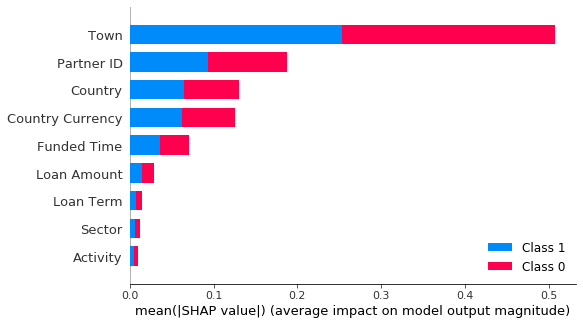

In [285]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

## XGboost

In [68]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

CPU times: user 964 ms, sys: 74.1 ms, total: 1.04 s
Wall time: 1.35 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int8)

In [70]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

In [71]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

In [72]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 

In [73]:
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

## Performance

In [74]:
class_labels = list(set(my_labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.9434
Precision: 0.9428
Recall: 0.9434
F1 Score: 0.9429

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       846
           1       0.90      0.86      0.88       267

    accuracy                           0.94      1113
   macro avg       0.93      0.91      0.92      1113
weighted avg       0.94      0.94      0.94      1113


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   0    1
Actual: 0        821   25
        1         38  229


the 'labels' keyword is deprecated, use 'codes' instead
the 'labels' keyword is deprecated, use 'codes' instead


### Feature Weights: This is based on the number of times a feature appears in a tree across the ensemble of trees
### Gain: This is based on the average gain of splits which use the feature
### Coverage: This is based on the average coverage (number of samples affected) of splits which use the feature

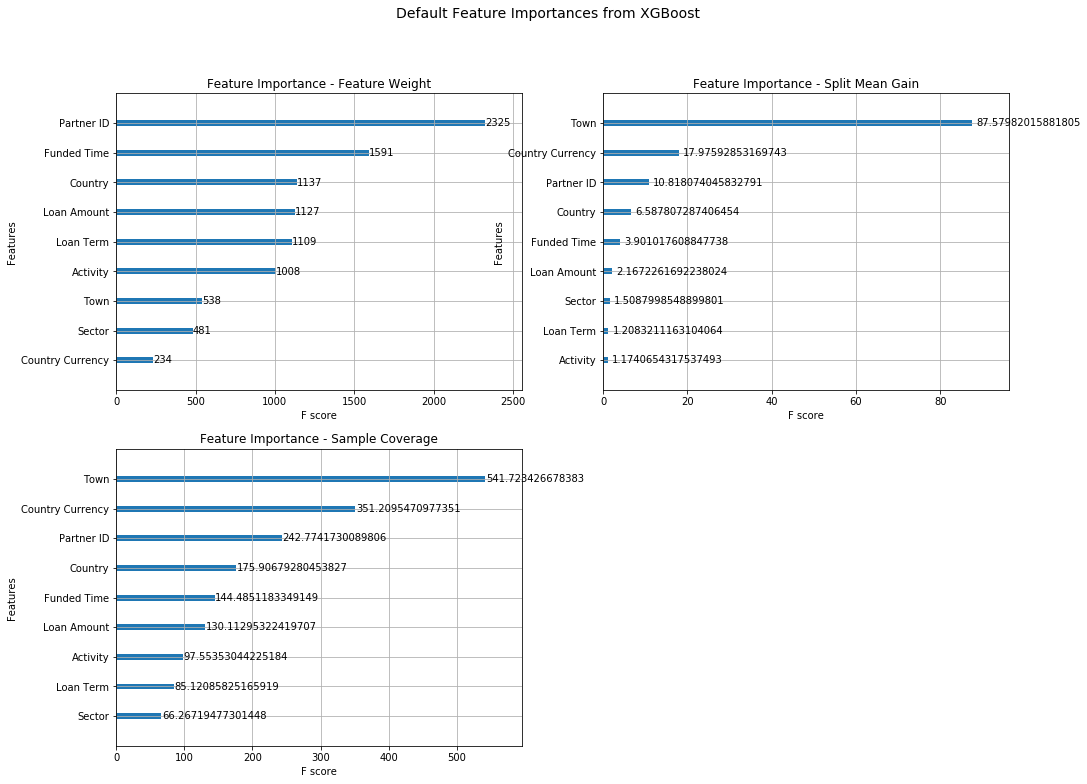

In [157]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

## explain with shap

In [75]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Expected Value: -2.08425


,0,1,2,3,4,5,6,7,8
0,-0.529892,-0.807365,-0.820181,0.0,-0.156824,-0.257884,-2.339677,0.018018,-2.894964
1,-0.700247,-0.073598,-0.801752,0.0,0.080872,-0.892373,-2.737302,-0.009584,-3.115843
2,0.962438,0.889593,-0.776371,0.0,0.159547,0.166009,-1.805745,-0.038519,-2.731301
3,-0.206560,0.170571,6.848159,0.0,-1.386347,0.112740,1.513848,0.003397,3.365507
4,-0.540108,-0.458838,-0.765898,0.0,0.334019,0.130054,0.758466,0.000080,4.789269


In [76]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:],
               link='logit')

In [77]:
my_labels == 0

308360    False
410807    False
207178    False
159068    False
228164    False
          ...  
431366     True
431573     True
434368     True
435114     True
440032     True
Name: Status, Length: 3709, dtype: bool

In [79]:
labels_disp[440032]

'defaulted'

In [82]:
shap.force_plot(explainer.expected_value, 
                shap_values[1112,:], X_test_disp.iloc[1112,:],
               link='logit')

In [ ]:
#shap.TreeExplainer(xgb).shap_interaction_values(X)

In [87]:
shap.force_plot(explainer.expected_value, 
                shap_values[:500,:], X_test_disp.iloc[:500,:],
               link='logit')

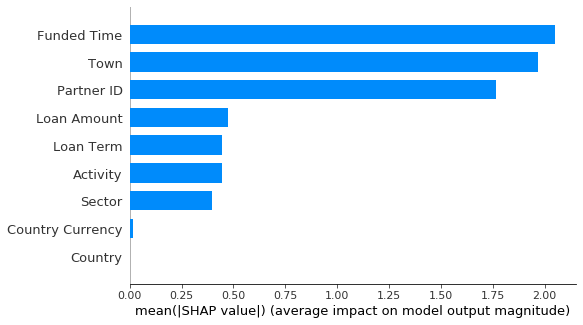

In [84]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

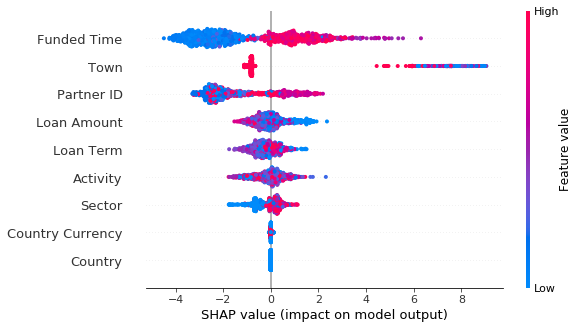

In [88]:
shap.summary_plot(shap_values, X_test)

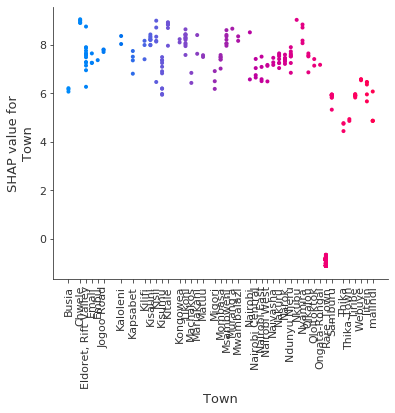

In [111]:
shap.dependence_plot(ind='Town', interaction_index='Town',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

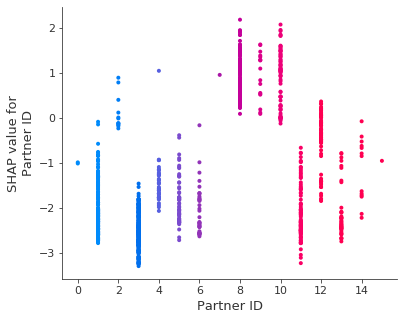

In [90]:
shap.dependence_plot(ind='Partner ID', interaction_index='Partner ID',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

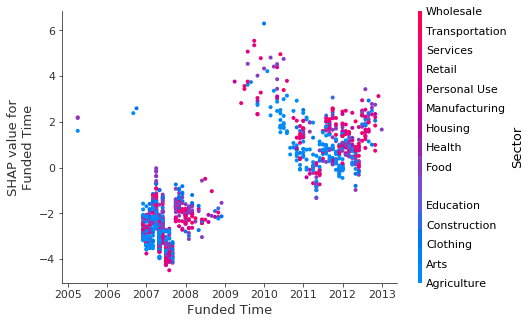

In [92]:
shap.dependence_plot(ind='Funded Time', interaction_index='Sector',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

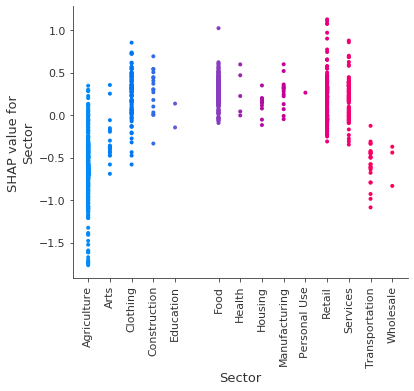

In [93]:
shap.dependence_plot(ind='Sector', interaction_index='Sector',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

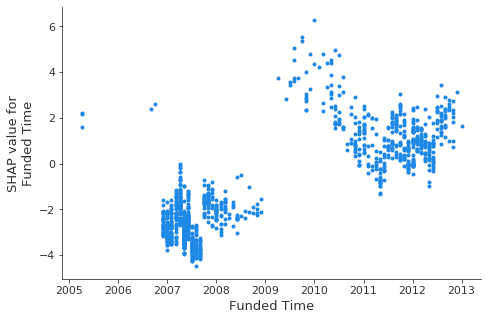

In [94]:
shap.dependence_plot(ind='Funded Time', interaction_index= None,
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

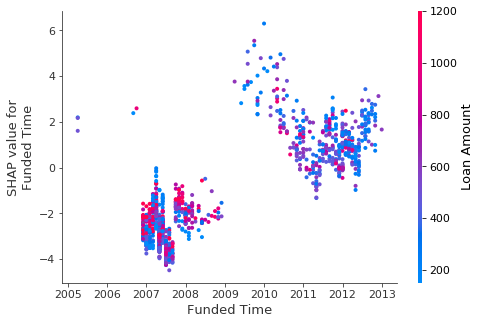

In [101]:
shap.dependence_plot(ind='Funded Time', interaction_index='Loan Amount',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

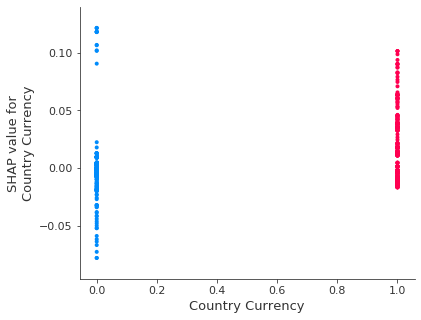

In [100]:
shap.dependence_plot(ind='Country Currency', interaction_index='Country Currency', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

In [179]:
df_disp[df_train['Country Currency'] == 0]

,Loan Amount,Loan Term,Town,Country,Sector,Activity,Partner ID,Country Currency,Funded Time
42612,1025,36,Kabul Afghanistan,Afghanistan,Food,Grocery Store,34,Afghanistan AFN,2008.3332
101689,575,18,Kabul Afghanistan,Afghanistan,Food,Bakery,34,Afghanistan AFN,2009.4165
81967,650,19,Kabul Afghanistan,Afghanistan,Services,Services,34,Afghanistan AFN,2009.0833
122785,625,20,Kabul Afghanistan,Afghanistan,Construction,Construction,34,Afghanistan AFN,2009.7497
25848,1025,36,Kabul Afghanistan,Afghanistan,Health,Pharmacy,34,Afghanistan AFN,2007.9996
...,...,...,...,...,...,...,...,...,...
276046,950,33,Rare_Town,Afghanistan,Food,Fruits & Vegetables,34,Afghanistan AFN,2011.3332
276083,700,27,Rare_Town,Afghanistan,Agriculture,Farming,34,Afghanistan AFN,2011.3332
276097,475,18,Rare_Town,Afghanistan,Services,Barber Shop,34,Afghanistan AFN,2011.3332
276106,500,20,Rare_Town,Afghanistan,Retail,Mobile Phones,34,Afghanistan AFN,2011.3332


## Afghanistan AFN always repay??

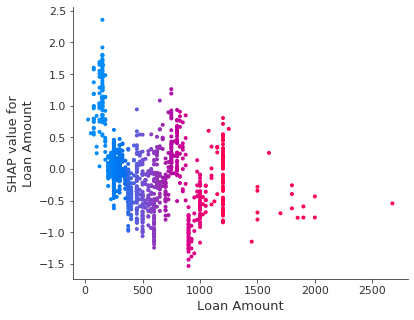

In [102]:
shap.dependence_plot(ind='Loan Amount', interaction_index='Loan Amount', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

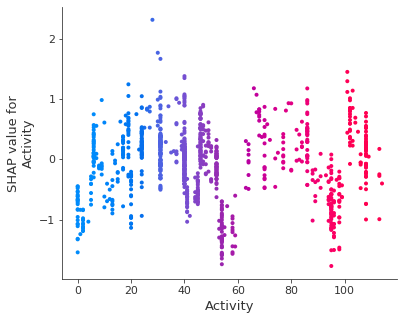

In [110]:
shap.dependence_plot(ind='Activity', interaction_index='Activity', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

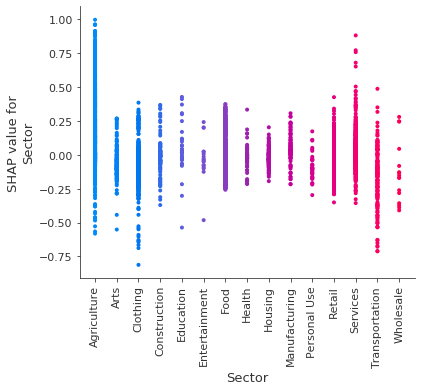

In [199]:
shap.dependence_plot(ind='Sector', interaction_index='Sector', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

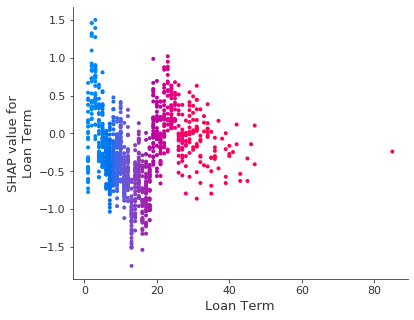

In [104]:
shap.dependence_plot(ind='Loan Term', interaction_index='Loan Term', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

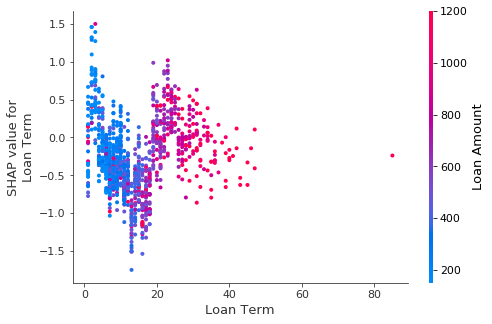

In [105]:
shap.dependence_plot(ind='Loan Term', interaction_index='Loan Amount', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

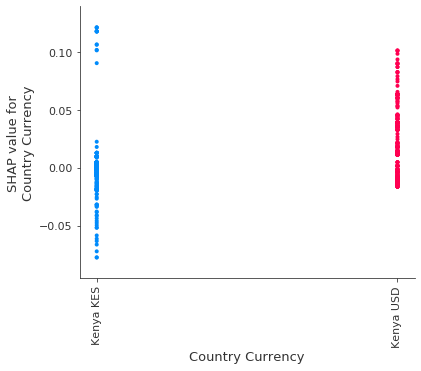

In [108]:
shap.dependence_plot(ind='Country Currency', interaction_index='Country Currency', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

## encoded categorical data and normalized 

In [33]:
def normalize_column(df_column, center_at_zero=False):
    """Converts an unnormalized dataframe column to a normalized 
    1D numpy array
    Default: normalizes between [0,1]
    (center_at_zero == True): normalizes between [-1,1] """

    normalized_array = np.array(df_column, dtype="float64")
    amax, amin = np.max(normalized_array), np.min(normalized_array)
    normalized_array -= amin
    if center_at_zero:
        normalized_array *= 2.0 / (amax - amin)
        normalized_array -= 1.0
    else:
        normalized_array *= 1.0 / (amax - amin)
    return normalized_array

In [34]:
def encode(df, categorical_columns, ordinal_columns):
    """Converts data in dataframe to numpy array that includes:
    1) one-hot encoded categorical columnhs
    2) normalized ordinal columns"""

    ohe = preprocessing.OneHotEncoder(handle_unknown="ignore", sparse=False)
    X = np.transpose(ohe.fit_transform(df[categorical_columns]))

    for c in ordinal_columns:
        X = np.vstack([X, normalize_column(df[c])])

    return np.transpose(X), ohe

In [35]:
train_length = len(df_train)
df_concatenated = pd.concat([df_train, df_test])

X_concatenated, encoder = encode(df_concatenated, categorical_columns, ordinal_columns)
y_concatenated_df = pd.get_dummies(df_concatenated["Status"], columns=["Status"])["defaulted"]

In [36]:
# concatenated ???
df_concatenated.shape

(143980, 10)

In [37]:
features = encoder.get_feature_names(categorical_columns).tolist()
for c in ordinal_columns:
    features.append(c)
X_concatenated_df = pd.DataFrame(X_concatenated, columns=features)

In [38]:
X_concatenated_df[status]

NameError: name 'status' is not defined

In [18]:
# Split the train from the test arrays
# X_train, X_test = X_concatenated[:train_length, :], X_concatenated[train_length:, :]
# y_train, y_test = y_concatenated[:train_length], y_concatenated[train_length:]
X_train, X_test, y_train, y_test = train_test_split(X_concatenated_df, y_concatenated_df, test_size = 0.2)

## Logistic Reg

In [19]:

# Import module for fitting
print("Logistic Regression")
y_pred_log, y_prob_log, model_titles = [], [], []
logmodel = LogisticRegression(
    solver="lbfgs",  # class_weight= {0:.1, 1:.9},
    penalty="l2",
    C=10.0,
    max_iter=500,
)

# Fit the model using the training data
logmodel.fit(X_train, y_train)

y_pred_log.append(logmodel.predict(X_test))
y_prob_log.append(logmodel.predict_proba(X_test)[:, 1])
model_titles.append("Logistic Regression")

Logistic Regression


## Random forest

In [20]:
print("training random forest")
# Import module for fitting
y_pred, y_prob, model_titles = [], [], []
rfmodel = RandomForestClassifier(
    n_estimators=80, max_depth=50  # class_weight= {0:.1, 1:.9},
)

# Fit the model using the training data
rfmodel.fit(X_train, y_train)

y_pred.append(rfmodel.predict(X_test))
y_prob.append(rfmodel.predict_proba(X_test)[:, 1])
model_titles.append("Random Forest")
#b = rfmodel.feature_importances_
print(rfmodel.feature_importances_)

training random forest


[8.01518884e-03 1.77089028e-05 1.60195038e-04 ... 5.48065801e-02
 5.39492334e-02 1.28227285e-01]


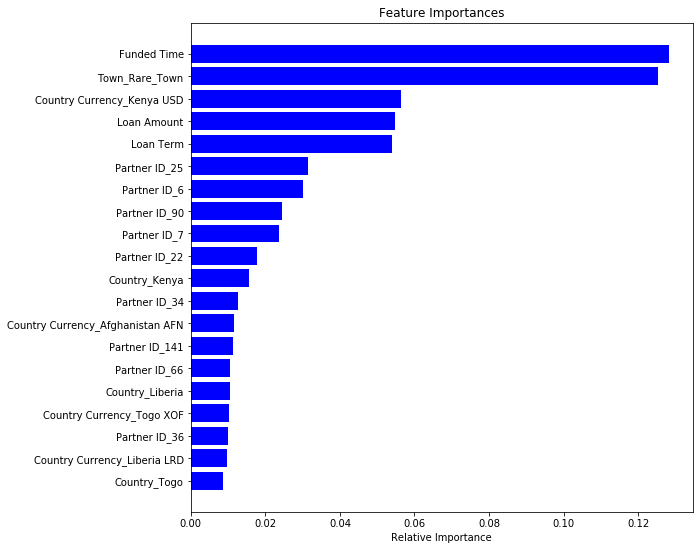

In [21]:
# b = rfmodel.feature_importances_
importances = rfmodel.feature_importances_
indices = np.argsort(importances)

j = -20
plt.figure(figsize=(9, 9))
plt.title('Feature Importances')
plt.barh(range(len(indices[j:])), importances[indices[j:]], color='b', align='center')
plt.yticks(range(len(indices[j:])), [features[i] for i in indices[j:]])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
# for shap, take 5000 rows
X_cut = X_concatenated_df[:1000]
y_cut = y_concatenated_df[:1000]
print(X_cut.shape, y_cut.shape)
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(X_cut, y_cut, test_size = 0.2)

(1000, 1084) (1000,)


In [23]:
y_pred, y_prob, model_titles = [], [], []
rfmodel_cut = RandomForestClassifier(
    n_estimators=80, max_depth=50  # class_weight= {0:.1, 1:.9},
)

rfmodel_cut.fit(X_train_cut, y_train_cut)

y_pred.append(rfmodel_cut.predict(X_test_cut))
y_prob.append(rfmodel_cut.predict_proba(X_test_cut)[:, 1])
model_titles.append("Random Forest with important features")

In [25]:
import shap
explainer = shap.TreeExplainer(rfmodel_cut)
shap_values = explainer.shap_values(X_train_cut)

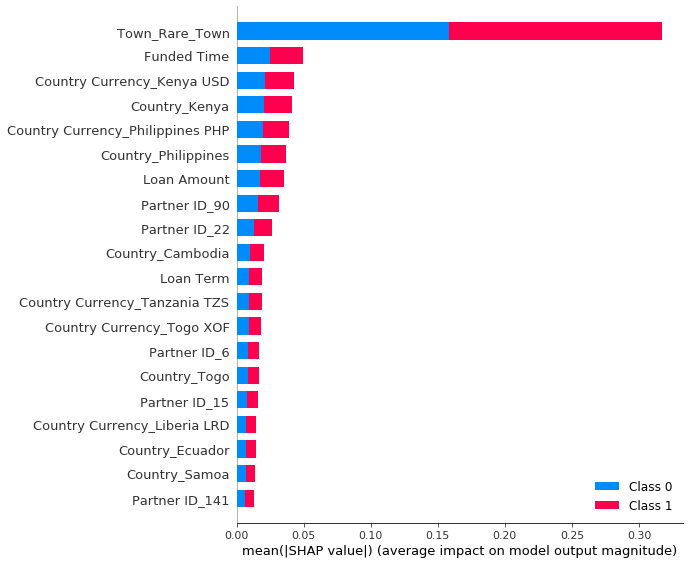

In [26]:
# summary plot
shap.summary_plot(shap_values, X_train_cut)

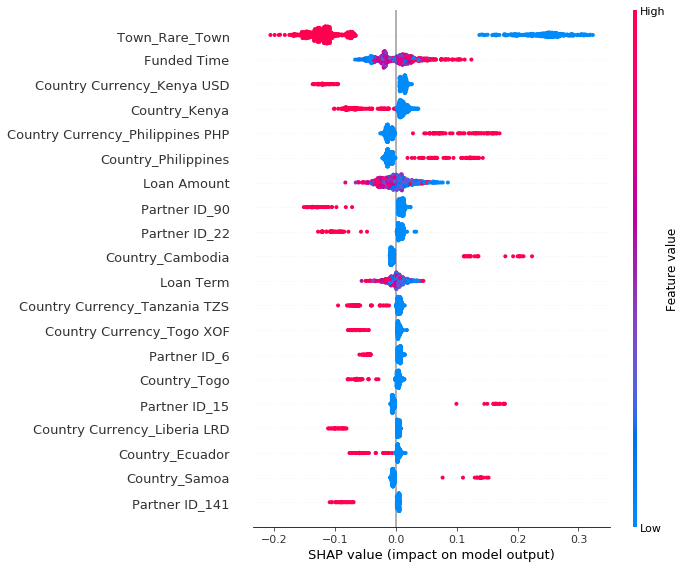

In [27]:
shap.summary_plot(shap_values[0], X_train_cut)

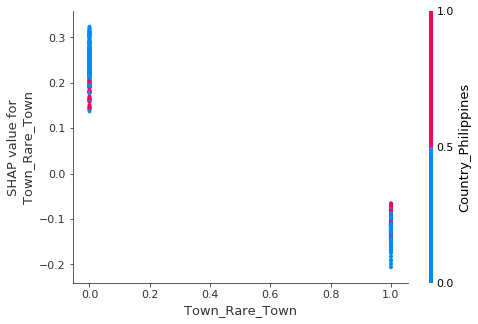

In [29]:
shap.dependence_plot("Town_Rare_Town", shap_values[0], X_train_cut)

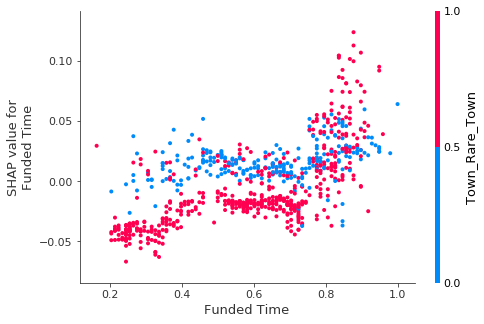

In [33]:
shap.dependence_plot("Funded Time", shap_values[0], X_train_cut)

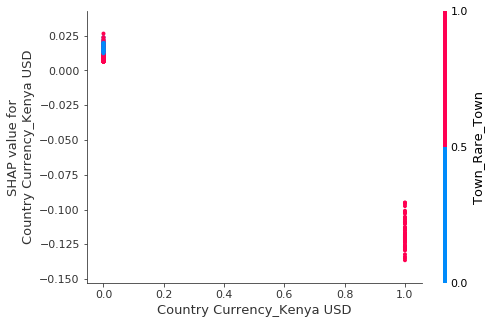

In [30]:
shap.dependence_plot("Country Currency_Kenya USD", shap_values[0], X_train_cut)

In [35]:
shap.force_plot(explainer.expected_value[0],
                shap_values[0][0,:],
                X_train_cut.iloc[0,:])

In [38]:
shap.force_plot(explainer.expected_value[1],
                shap_values[1][0:5],
                X_train_cut.iloc[0:5])